In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
#Audio-data augmentation
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
#Various audio processing functionalities
import librosa
#Just to find the ceil 
import math
#Visualization of model history
import matplotlib.pyplot as plt
#Memory maps and various computations involving arrays
import numpy as np
#File read/information retrieval
import os
#CSV file manipulation
import pandas as pd
#To shuffle and split the dataset. We use it here to split indices of memory maps.
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as keras
import time
from tensorflow.python.keras.saving import hdf5_format
import h5py
import gc
import sys

##### Assumptions 
- Any class in csv file should have a viable number of songs in them. The amount of songs we take for training and testing is equivalent to the n(songs) of that class which has the minimum amount of songs -> to balance the dataset.
- Don't have variables named X,y,X_train ,X_validation,X_test,y_train,y_validation,y_test in this script since it will either get deleted or the memory maps won't get created. We are using global so warning
- Memory maps on creation have a default value of 0 array with shape we mention on creation  [To extract the actual size of added data]
- Values produced by mfcc are of data type float64 
- Number of classes less than 255 since we use uint8 to create memory maps.
- In create_dataset function, we use 8 as a constant to calculate train/validation/test sizes since float64 uses 8 bytes

In [12]:
def Augment_Song(signal,sample_rate,n_augmentations):
    signals=list()
    signals.append(signal)
    #print("Original")
    if(n_augmentations<=0):
        return signals 
    transform1 = AddGaussianNoise(min_amplitude=0.001,max_amplitude=0.015,p=1.0)
    augmented_sound = transform1(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Gaussian Noise")
    if(n_augmentations<=1):
        return signals 
    transform2 =  TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5)
    augmented_sound = transform2(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Time Stretch")
    if(n_augmentations<=2):
        return signals 
    transform3=PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
    augmented_sound=transform3(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Pitch Shift")
    if(n_augmentations<=3):
        return signals 
    transform4=Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5)
    augmented_sound=transform4(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Shift")
    if(n_augmentations<=4):
        return signals 
    transform5= Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-1, max_semitones=1, p=0.5),
    Shift(min_fraction=-0.2, max_fraction=0.2, p=0.5),
    ])
    augmented_sound=transform5(signal, sample_rate=sample_rate)
    signals.append(augmented_sound)
    #print("Combined Transforms") 
    return signals

In [13]:
def create_csv(DATASET_PATH,CSV_PATH):
    """
    DATASET_PATH -> Directory which will have folders (classes) of audio files.
    CSV_PATH -> Path of csv file
    CSV file structure : ['Filename','Genre','Path']
        Filename is the name of the audio file including extension
        Genre will be the name of the parent folder of the audio file. This assumes audio files are stored in folders having their respective class (genre) name.
        Path will be the path of the audio file including the filename as well.
    """
    df=pd.DataFrame(list(),columns=["Filename","Genre","Path","Test","Error","Bad_Segments"])
    for genre_folder in next(os.walk(DATASET_PATH))[1]:
        for file in next(os.walk(os.path.join(DATASET_PATH,genre_folder)))[2]:
            df.loc[len(df.index)]=[file,genre_folder.title(),os.path.join(DATASET_PATH,genre_folder,file),0,np.nan,np.nan]
    print("Dataset csv file created at",CSV_PATH)
    display(df)
    df.to_csv(CSV_PATH,index=False)
    #print(f"Path of the created csv file : {CSV_PATH}. If the dataset doesn't change in the future, Pass the path of that csv file as the function parameter to avoid writing csv file over and over again.")

In [14]:
def create_test_set(CSV_PATH,test_percentage=10):
    """
    Creates or updates test set depending on given split ratio and updates to csv file.
    df -> Path of the csv file which has Filename, Genre, Path of the audio files or a dataframe containing those columns.
    test_percentage -> percentage of the dataset set aside for testing. 
    Entire audio files not just segments will be removed from training/validation to avoid data leakage. 
    """
    df=pd.read_csv(CSV_PATH)
    df=df.drop_duplicates(['Path'])
    #We are filtering errors here since we are writing this dataframe as the csv file. We would still like to have those files in the main csv file.
    if("Test" not in df.columns):
        df['Test']=0
    if("Error" not in df.columns):
        df['Error']=""
    if("Bad_Segments" not in df.columns):
        df['Bad_Segments']=""
    genre_count_list=list(df["Genre"].value_counts())
    required_test_set_size=int(min(genre_count_list)/test_percentage)
    for genre in list(df["Genre"].unique()):
        test_df=df.loc[(df.Test==1) & (df.Genre==genre) & (df['Error']!="Unreadable file")] #df['Error'].isnull() If we want to remove all types of error
        train_df=df.loc[(df.Test==0) & (df.Genre==genre) & (df['Error']!="Unreadable file")]  #df['Error'].isnull()
        current_test_set_size_for_genre=len(test_df)
        if(current_test_set_size_for_genre>required_test_set_size):
            df.loc[test_df.sample(n=current_test_set_size_for_genre-required_test_set_size).index,'Test']=0
        elif(current_test_set_size_for_genre<required_test_set_size):
            df.loc[train_df.sample(n=required_test_set_size-current_test_set_size_for_genre).index,'Test']=1
        else:
            pass
    print("Training set")
    display(df.loc[df.Test==0])
    print("Testing set")
    display(df.loc[df.Test==1])
    df.to_csv(CSV_PATH,index=False)

In [15]:
def clean(MEMORY_MAPPING_PATH,s,file_list=None):
    """
    MEMORY_MAPPING_PATH -> directory of memory map files
    s -> what to remove? Either variables, files or both
    """
    #if(s=="csv")
    if(file_list==None):
        file_list=["X","y","X_train","X_validation","X_test","y_train","y_validation","y_test"]
    if((s=="variables") or (s=="both")):
        for variable in file_list:
            #myVars = locals() 
            #del doesn't work if locals since it returns a copy of the directory not the directory itself like globals. So for our usecase, we have to use globals [may be dangerous.]
            myVars = globals()
            try:
                del myVars[variable]
            except NameError:
                continue
            except KeyError:
                continue
        gc.collect()
    if((s=="files") or (s=="both")):
        for file in file_list:
            try:
                os.remove(os.path.join(MEMORY_MAPPING_PATH,file+".mymemmap"))
            except FileNotFoundError:
                continue

In [39]:
def load_data(CSV_PATH,MEMORY_MAPPING_PATH,test,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations):
    """
    Loads in data onto memory maps from either a csv file or a dataframe. 
    """
    starting_time=time.time()
    main_df=pd.read_csv(CSV_PATH)
    print("CSV file read.")
    #Getting either training set or testing set depending on given paramater
    df=main_df.loc[(main_df.Test==int(test)) & (main_df['Error']!="Unreadable file")]    #main_df['Error'].isnull()
    print("Skipped these files : ")
    display(main_df.loc[(main_df.Test==int(test)) & (main_df['Error']=="Unreadable file")])
    min_genre_count=min(list(df["Genre"].value_counts()))
    print("Classes distribution :",dict(df["Genre"].value_counts()))
    balanced_df=pd.DataFrame(list(),columns=df.columns)
    for genre in list(df["Genre"].unique()):
        #Taking a random sample from the dataset
        temp_df=df.loc[df["Genre"]==genre].sample(n=min_genre_count)
        balanced_df = pd.concat([balanced_df, temp_df], ignore_index=True, sort=False)
    df=balanced_df
    print("Test" if test==True else "Training",f"Dataset balanced to have only {min_genre_count} data points per class.")
    #To shuffle. Not needed since we are using train test split for shuffling which is a better way since it will shuffle segments as well not just songs.
    #df=df.sample(n = len(df.index))
    if("Error" not in df.columns):
        df['Error']=np.nan    
    if("Bad_Segments" not in df.columns):
        df['Bad_Segments']=np.nan
    #Getting genre list which we will be using to set the labels.
    genre_list=sorted(list(df["Genre"].unique()))
    print(f"Classes present in the dataframe [index of this list will be the label for that class]: {genre_list}")
    try:
        global temp_X
        global temp_y 
        #Deleting memory map files so that we don't face issues when creating memory maps here.
        clean(MEMORY_MAPPING_PATH,"files",file_list=["X","y"])
                
        SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
        samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
        n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
       
        #Creating memory maps
        max_input_size=len(df.index)*(n_augmentations+1)*n_segments
        temp_X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='w+', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        temp_y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='w+', shape=(max_input_size,))
        print("Empty memory maps X.mymemmap and y.mymemmap created.")

        #audio file count
        song_count=1
        #viable mfcc array count
        count=0
        test_null_signal_array=np.zeros((n_mfcc_vectors_per_segment,n_mfcc))
        test_null_signal_array[:,0]=-1131.370849898476
        for index,row in df.iterrows():
            
            #Updates csv file on bad segments and what issue we have on those segments. This is done only for non-augmented file since we don't store augmented file information in csv file.
            bad_segments=list()
            error_messages=list()
            
            #print(f"{song_count}. {row['Filename']} : {genre_list.index(row['Genre'])}")
            try:
                signal, sample_rate = librosa.load(path, sr=SAMPLE_RATE,duration=TRACK_DURATION)
            except Exception as e:
                print(f"{song_count}. {row['Filename']} : {genre_list.index(row['Genre'])}")
                print("ERROR : Couldn't read file:")
                #Basically file is unreadable so every segment is deemed as bad here.
                bad_segments=" ".join(str(x) for x in list(range(0,n_segments)))
                error_messages.append("Unreadable file")
                main_df.loc[main_df.Path==row['Path'],'Error']=",".join(str(x) for x in error_messages)
                main_df.loc[main_df.Path==row['Path'],'Bad_Segments']=" ".join(str(x) for x in bad_segments)
                continue
            signals=Augment_Song(signal,sample_rate,n_augmentations)
            for signal in signals:
                for d in range(n_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment
                    #n_mfcc values beyond 128 produces 128 mfcc only.
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T   
                    #This check makes sure the shape of the input is consistent. Assuming this stays in, we can assume shape to be (n_mfcc_vectors_per_segment,n_mfcc) for each segment
                    if(mfcc.shape==(n_mfcc_vectors_per_segment,n_mfcc)):
                        if(np.all(np.equal(test_null_signal_array,mfcc))):
                            print(f"ERROR : Segment {d} skipped because signal value is a 0 array.")
                            bad_segments.append(d)
                            error_messages.append("0 signal")
                            continue
                        if(np.any(np.isnan(mfcc))):
                            print(f"ERROR : Segment {d} skipped because mfcc array contains nan values.")
                            bad_segments.append(d)
                            error_messages.append("nan value in mfcc array")
                            continue
                        if(np.any(np.isinf(mfcc))):
                            print(f"ERROR : Segment {d} skipped because mfcc array contains inf as a value.")
                            bad_segments.append(d)
                            error_messages.append("inf value in mfcc array")
                            continue
                        temp_X[count,:]=mfcc
                        temp_y[count]=genre_list.index(row['Genre'])
                        count+=1
                    else:
                        print(f"ERROR : Segment {d} skipped because mfcc length not consistent.")
                        bad_segments.append(d)
                        error_messages.append("mfcc array length wrong")
            if(len(bad_segments)>0):
                print(f"{song_count}. {row['Filename']} : {genre_list.index(row['Genre'])}")
                main_df.loc[main_df.Path==row['Path'],'Error']=",".join(str(x) for x in error_messages)
                main_df.loc[main_df.Path==row['Path'],'Bad_Segments']=" ".join(str(x) for x in bad_segments)
            song_count+=1
        main_df.to_csv(CSV_PATH,index=False)
        clean(MEMORY_MAPPING_PATH,"variables",file_list=["temp_X","temp_y"])
        ending_time=time.time()
        print("Data loaded : ",ending_time-starting_time,"seconds",end="\n")
    except Exception as e:
        print("Memory and files cleaned because exception occured :",e)
        clean(MEMORY_MAPPING_PATH,"both",file_list=["X","y","temp_X","temp_y"])
        raise Exception(e)
    except KeyboardInterrupt:
        #If user interrupts this process, X and y can have corrupt values since it was in the middle of adding data. 
        #We are removing the memory map files as well as deleting the variables for safety.
        #deleting variables required since referenced to the memory map will still be in memory 
        #which will not allow us to run the code again since WinError which tells us some other process is using the file.
        clean(MEMORY_MAPPING_PATH,"both",file_list=["X","y","temp_X","temp_y"])
        raise KeyboardInterrupt("Deleted memory maps and variables from memory since values will be corrupt")

In [34]:
path="D:/Music/Ekstrak - Belt.mp3"
duration=librosa.get_duration(filename=path)
#duration - 30s so that we don't go beyond the length of the audio file
offset=random.randint(0,(duration-TRACK_DURATION) if (duration-TRACK_DURATION)>=0 else duration)
signal, sample_rate = librosa.load(path, sr=SAMPLE_RATE,offset=offset,duration=TRACK_DURATION)

In [17]:
def Preprocess(MEMORY_MAPPING_PATH,CSV_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations):
    """
    """
    Function_start_time=time.time()
    
    #We are using global here since we will be using global() to delete variables off of memory. locals() returns the copy of the namespace not the actual one. We are deleting variables dynamically. 
    global X
    global y
    global X_train 
    global X_validation
    global X_test
    global y_train
    global y_validation
    global y_test 
    
    #creates test set csv file else if it already exists, appends or deletes data from it if not consistent with ratio
    test_percentage=10
    create_test_set(CSV_PATH,test_percentage)
    
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
    n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
        
    try:
        
        #delete memory mapping if present in directory
        file_list=["X","y","X_train","X_validation","X_test","y_train","y_validation","y_test"]
        clean(MEMORY_MAPPING_PATH,"both",file_list)
        
        #Loading for training set.
        test=False
        load_data(CSV_PATH,MEMORY_MAPPING_PATH,test,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations)
        file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"))
        max_input_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
        X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='r', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='r', shape=(max_input_size,))
        #Getting the actual size of the training set since we might encounter segment errors and unreadable files.
        print("length calculated is :",len(X)==max_input_size)
        actual_size=max_input_size #len(X)
        zero_array=np.zeros((n_mfcc_vectors_per_segment, n_mfcc),dtype=float)
        for i in range(-1,-len(X),-1):
            if(np.array_equal(X[-i],zero_array)):
                actual_size-=1
        index_list=np.arange(0, actual_size, 1, dtype=int)
        #Splitting from training set, the validation set.
        validation_ratio=0.2
        train_indices,validation_indices=train_test_split(index_list,test_size=validation_ratio,shuffle=True)
        print(f"Splitting X in the ratio : {validation_ratio}. \n(Training + Validation) set size : {actual_size}. \nTrain set size : {len(train_indices)} \nValidation set size : {len(validation_indices)}")
        #Creating empty memory maps for train and validation
        X_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"), dtype='float64', mode='w+', shape=(len(train_indices), n_mfcc_vectors_per_segment, n_mfcc))
        X_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"), dtype='float64', mode='w+', shape=(len(validation_indices), n_mfcc_vectors_per_segment, n_mfcc))
        y_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_train.mymemmap"), dtype='uint8', mode='w+', shape=(len(train_indices),))
        y_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_validation.mymemmap"), dtype='uint8', mode='w+', shape=(len(validation_indices),))
        print("Empty memory maps created for train and validation")
        #Placing respective values in validation and train memory maps.
        for index in range(0,actual_size):
            #print(index,end=":")
            if(index in train_indices):
                #print("train")
                X_train[np.where(train_indices == index)[0][0],:]=X[index]
                y_train[np.where(train_indices == index)[0][0]]=y[index]
            elif(index in validation_indices):
                #print("validation")
                X_validation[np.where(validation_indices == index)[0][0],:]=X[index]
                y_validation[np.where(validation_indices == index)[0][0]]=y[index]
            else:
                print(f"ERROR : Index {count} not in train or validation indices")  
        print("Train and validation memory maps written.")
        clean(MEMORY_MAPPING_PATH,"variables",["X","y"])
        
        #Avoiding augmentation here since we assume test to be the actual real representation that we want to perform well on.
        test=True
        load_data(CSV_PATH,MEMORY_MAPPING_PATH,test,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,0)
        file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"))
        max_input_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
        X = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X.mymemmap"), dtype='float64', mode='r', shape=(max_input_size, n_mfcc_vectors_per_segment, n_mfcc))
        y = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y.mymemmap"), dtype='uint8', mode='r', shape=(max_input_size,))
        actual_size=max_input_size #len(X)
        for i in range(-1,-len(X),-1):
            if(np.array_equal(X[-i],zero_array)):
                actual_size-=1
        print(f"Test set size : {actual_size}")
        X_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"), dtype='float64', mode='w+', shape=(actual_size, n_mfcc_vectors_per_segment, n_mfcc))
        y_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_test.mymemmap"), dtype='uint8', mode='w+', shape=(actual_size,))
        X_test[:]=X[:actual_size]
        y_test[:]=y[:actual_size]
        print("Test memory map written.")
        clean(MEMORY_MAPPING_PATH,"variables",file_list)
        
    except Exception as e:
        print("Exception occured : ",e)
        clean(MEMORY_MAPPING_PATH,"both",file_list)
        raise Exception(e)
    except KeyboardInterrupt:
        clean(MEMORY_MAPPING_PATH,"both",file_list)
        raise KeyboardInterrupt("Deleted memory maps and variables from memory since values will be corrupt")
    Function_end_time=time.time()
    print(f"\n\n\nPreprocessing Execution Time : {Function_end_time-Function_start_time}")

In [18]:
def build_model(input_shape,n_classes):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(n_classes, activation='softmax'))

    return model

In [19]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [20]:
def predict(model, X, y):
    """
    X to be in shape (n_mfcc_vectors_per_segment,n_mfcc)
    """
    X = X[..., np.newaxis]
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    #prediction=list(prediction[0])
    prediction=prediction[0]
    predicted_index = np.argmax(prediction)
    #print("Target: {}, Predicted label: {}".format(y, predicted_index))
    return predicted_index

In [21]:
def create_dataset(MEMORY_MAPPING_PATH,n_mfcc,n_segments,n_mfcc_vectors_per_segment):
    """
    """
    s=time.time()

    global X_train 
    global X_validation
    global X_test
    global y_train
    global y_validation
    global y_test 
    
    memory_map_directory_file_list=next(os.walk(MEMORY_MAPPING_PATH))[2]
    required_memory_maps_list=["X_train.mymemmap","X_validation.mymemmap","X_test.mymemmap","y_train.mymemmap","y_validation.mymemmap","y_test.mymemmap"]
    #If the required maps not in the given directory
    if(not(all(item in memory_map_directory_file_list for item in required_memory_maps_list))):
        raise ValueError('Memory Map directory may be incorrect since required memory maps not found. Use remove=True if memory maps were not created during the previous iterations.')
        
    #Here 8 is because float64 uses 8 bytes. [float64 uses 64 bits -> 8 bytes]
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"))
    train_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"))
    validation_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    
    file_size = os.path.getsize(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"))
    test_size=int(file_size/(n_mfcc_vectors_per_segment*n_mfcc*8))
    print(f"Train, Validation, Test Memory maps of sizes {train_size}, {validation_size}, {test_size} read respectively")
    
    X_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_train.mymemmap"), dtype='float64', mode='r', shape=(train_size, n_mfcc_vectors_per_segment, n_mfcc))
    X_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_validation.mymemmap"), dtype='float64', mode='r', shape=(validation_size,n_mfcc_vectors_per_segment, n_mfcc))
    X_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"X_test.mymemmap"), dtype='float64', mode='r', shape=(test_size, n_mfcc_vectors_per_segment, n_mfcc))
    y_train = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_train.mymemmap"), dtype='uint8', mode='r', shape=(train_size,))
    y_validation = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_validation.mymemmap"), dtype='uint8', mode='r', shape=(validation_size,))
    y_test = np.memmap(os.path.join(MEMORY_MAPPING_PATH,"y_test.mymemmap"), dtype='uint8', mode='r', shape=(test_size,))


    input_example_shape =  X_train[0].shape
    input_dtype = np.float64
    print(f"Input example shape : {input_example_shape} Input datatype : {input_dtype}")

    # generator function
    def X_train_generator():
        return iter(X_train)
    def X_validation_generator():
        return iter(X_validation)
    def X_test_generator():
        return iter(X_test)

    # create tf dataset from generator fn
    X_train_dataset = tf.data.Dataset.from_generator(
        generator=X_train_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_validation_dataset = tf.data.Dataset.from_generator(
        generator=X_validation_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )
    # create tf dataset from generator fn
    X_test_dataset = tf.data.Dataset.from_generator(
        generator=X_test_generator,
        output_types=input_dtype,
        output_shapes=input_example_shape,
    )

    label_example_shape=y_train[0].shape
    label_data_dtype=np.uint8
    print(f"Label example shape : {label_example_shape} Label datatype : {label_data_dtype}")

    # generator function
    def y_train_generator():
        return iter(y_train)
    def y_validation_generator():
        return iter(y_validation)
    def y_test_generator():
        return iter(y_test)

    # create tf dataset from generator fn
    y_train_dataset = tf.data.Dataset.from_generator(
        generator=y_train_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_validation_dataset = tf.data.Dataset.from_generator(
        generator=y_validation_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )
    # create tf dataset from generator fn
    y_test_dataset = tf.data.Dataset.from_generator(
        generator=y_test_generator,
        output_types=label_data_dtype,
        output_shapes=label_example_shape
    )

    train_dataset= tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
    validation_dataset= tf.data.Dataset.zip((X_validation_dataset, y_validation_dataset))
    test_dataset= tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

    def RESHAPE(tensor_value,label):
        tensor_value=tf.reshape(tensor_value,(input_example_shape[0], input_example_shape[1],1))
        tensor_value.set_shape(tensor_value.shape)
        return (tensor_value,label)

    train_dataset = train_dataset.map(RESHAPE)
    validation_dataset = validation_dataset.map(RESHAPE)
    test_dataset = test_dataset.map(RESHAPE)

    train_batch=train_dataset.batch(32)
    validation_batch=validation_dataset.batch(32)
    test_batch=test_dataset.batch(32)

    print(f"Dataset created : {time.time()-s} Seconds")
    return train_batch,validation_batch,test_batch

In [22]:
def training(path=None,preprocess=True,remove=True,SAMPLE_RATE=22050,TRACK_DURATION = 30,n_mfcc=13,n_fft=2048,hop_length=512,n_segments=10,n_augmentations=0):
    """
    MEMORY_MAPPING_PATH is where we will store the mfcc numpy arrays of train,test,validation input and labels. [6 files total]
    ERROR_PATH -> csv file which will include files that are unreadable or segments inside those files that are corrupt.
    MODEL_SAVE_DIRECTORY -> The path where we want to save the model.
    If no csv file, assuming mp3/wav files are in respective genre folder where folder name = genre label
    If there is a csv file with dataset, columns = [Filename,Genre,Path]
    DATASET_PATH must be given if csv file of audio files is not there.
    DATASET_PATH AND CSV_PATH need not be given since we will read directly from the csv file - the path of the audio files.
    remove -> whether we want to remove existing memory maps or not. This WILL avoid preprocessing. If remove = True and memory maps not in location, will throw error. 
    SAMPLE_RATE= The number of data points per second in the audio file. Default is 22050.
    TRACK_DURATION = 30
    n_mfcc=13
    n_fft=2048
    hop_length=512
    n_segments=10
    n_augmentations=0
    """
    s=time.time()
    """
    old_stdout = sys.stdout
    log_file = open(os.path.join(DATASET_PATH,"message.log"),"w")
    sys.stdout = log_file
    """
    #numpy memory mapping gets created, error_csv gets created
    file_list=next(os.walk(path))[2]
    required_file_list=["Audio_Dataset.csv","X_train.mymemmap","X_validation.mymemmap","X_test.mymemmap","y_train.mymemmap","y_validation.mymemmap","y_test.mymemmap"]
    CSV_PATH=os.path.join(path,"Audio_Dataset.csv")
    MEMORY_MAPPING_PATH=path
    MODEL_SAVE_DIRECTORY=os.path.join(path,"Model.h5")
    if(remove==True and preprocess==False):
        raise ValueError("We can't remove csv files and memory maps and then do training since we need the data. Set preprocess as True so that we create csv files based on mp3/wav files after removing previous iterations' csv and memory maps")
    elif(remove==False and preprocess==True):
        print("Assuming Audio_Dataset.csv and memory maps with respective names : \"X_train.mymemmap\",\"X_validation.mymemmap\",\"X_test.mymemmap\",\"y_train.mymemmap\",\"y_validation.mymemmap\",\"y_test.mymemmap\" are present")
        if(set(required_file_list).issubset(set(file_list))):
            Preprocess(MEMORY_MAPPING_PATH,CSV_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations)
        else:
            raise ValueError(set(required_file_list).difference(set(file_list)),"does not exist. Set remove = True to start from scratch.")
    elif(remove==True and preprocess==True):
        create_csv(DATASET_PATH,CSV_PATH)
        Preprocess(MEMORY_MAPPING_PATH,CSV_PATH,SAMPLE_RATE,TRACK_DURATION,n_mfcc,n_fft,hop_length,n_segments,n_augmentations)        
    else:
        pass
    SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
    samples_per_segment = int(SAMPLES_PER_TRACK / n_segments)
    n_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    train_batch,validation_batch,test_batch=create_dataset(MEMORY_MAPPING_PATH,n_mfcc,n_segments,n_mfcc_vectors_per_segment)

    df=pd.read_csv(CSV_PATH)
    n_classes=len(list(df["Genre"].unique()))
    genre_list=sorted(list(df["Genre"].unique()))
    del df
    input_shape=(n_mfcc_vectors_per_segment, n_mfcc,1)
    model=build_model(input_shape,n_classes)
    print(f"Model built with input shape : {input_shape} and output classes : {n_classes}")

    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model compiled")
    model.summary()
    """
    sys.stdout = old_stdout
    log_file.close()
    del log_file
    """
    history = model.fit(train_batch,epochs=10,validation_data=validation_batch,verbose=1)
    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(test_batch, verbose=2)
    #Performance csv.loc[len(index)]=[MODEL_SAVE_DIRECTORY,test_loss,test_acc]  
    """
    old_stdout = sys.stdout
    log_file = open(os.path.join(DATASET_PATH,"message.log"),"a")
    sys.stdout = log_file
    """
    print('\nTest accuracy:', test_acc)

    with h5py.File(MODEL_SAVE_DIRECTORY, mode='w') as f:
        hdf5_format.save_model_to_hdf5(model, f)
        f.attrs['Genre_List'] = genre_list
        f.attrs["SAMPLE_RATE"] = SAMPLE_RATE
        f.attrs["TRACK_DURATION"]=TRACK_DURATION
        f.attrs["n_mfcc"]=n_mfcc
        f.attrs["n_fft"]=n_fft
        f.attrs["hop_length"]=hop_length
        f.attrs["n_segments"]=n_segments
    clean(MEMORY_MAPPING_PATH,"variables")
    print(f"MODEL SUCESSFULLY SAVED AT {MODEL_SAVE_DIRECTORY}")
    print(f"Training Execution Time : {time.time()-s} Seconds") 
    """
    sys.stdout = old_stdout
    log_file.close()
    """

In [32]:
DATASET_PATH="D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original"
SAMPLE_RATE=22050
TRACK_DURATION = 30
n_mfcc=13
n_fft=2048
hop_length=512
n_segments=10
n_augmentations=0

Assuming Audio_Dataset.csv and memory maps with respective names : "X_train.mymemmap","X_validation.mymemmap","X_test.mymemmap","y_train.mymemmap","y_validation.mymemmap","y_test.mymemmap" are present
Training set


,Filename,Genre,Path,Test,Error,Bad_Segments
0,blues.00000.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
2,blues.00002.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
3,blues.00003.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
4,blues.00004.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
5,blues.00005.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
...,...,...,...,...,...,...
995,rock.00095.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
996,rock.00096.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
997,rock.00097.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN
998,rock.00098.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,NaN,NaN


Testing set


,Filename,Genre,Path,Test,Error,Bad_Segments
1,blues.00001.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
18,blues.00018.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
30,blues.00030.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
40,blues.00040.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
49,blues.00049.wav,Blues,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
...,...,...,...,...,...,...
962,rock.00062.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
981,rock.00081.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
987,rock.00087.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN
990,rock.00090.wav,Rock,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,1,NaN,NaN


CSV file read.
Skipped these files : 


,Filename,Genre,Path,Test,Error,Bad_Segments
554,jazz.00054.wav,Jazz,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,Unreadable file,0 1 2 3 4 5 6 7 8 9


Classes distribution : {'Blues': 90, 'Classical': 90, 'Country': 90, 'Disco': 90, 'Hip-Hop': 90, 'Metal': 90, 'Pop': 90, 'Reggae': 90, 'Rock': 90, 'Jazz': 89}
Training Dataset balanced to have only 89 data points per class.
Classes present in the dataframe [index of this list will be the label for that class]: ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
Empty memory maps X.mymemmap and y.mymemmap created.
ERROR : Segment 9 skipped because mfcc length not consistent.
155. classical.00051.wav : 1
ERROR : Segment 9 skipped because mfcc length not consistent.
229. country.00007.wav : 2
ERROR : Segment 9 skipped because mfcc length not consistent.
329. disco.00014.wav : 3
ERROR : Segment 9 skipped because mfcc length not consistent.
385. hiphop.00032.wav : 4
Data loaded :  117.41974234580994 seconds
length calculated is : True
Splitting X in the ratio : 0.2. 
(Training + Validation) set size : 8896. 
Train set size : 7116 
Validation set s

,Filename,Genre,Path,Test,Error,Bad_Segments
554,jazz.00054.wav,Jazz,D:/Downloads/MGR Data/Data/GTZAN/Data/genres_o...,0,Unreadable file,0 1 2 3 4 5 6 7 8 9


Classes distribution : {'Blues': 10, 'Classical': 10, 'Country': 10, 'Disco': 10, 'Hip-Hop': 10, 'Jazz': 10, 'Metal': 10, 'Pop': 10, 'Reggae': 10, 'Rock': 10}
Test Dataset balanced to have only 10 data points per class.
Classes present in the dataframe [index of this list will be the label for that class]: ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
Empty memory maps X.mymemmap and y.mymemmap created.
Data loaded :  13.3425452709198 seconds
Test set size : 1000
Test memory map written.



Preprocessing Execution Time : 132.24530506134033
Train, Validation, Test Memory maps of sizes 7116, 1780, 1000 read respectively
Input example shape : (130, 13) Input datatype : <class 'numpy.float64'>
Label example shape : () Label datatype : <class 'numpy.uint8'>
Dataset created : 0.21512055397033691 Seconds
Model built with input shape : (130, 13, 1) and output classes : 10
Model compiled
Model: "sequential_3"
____________________________________

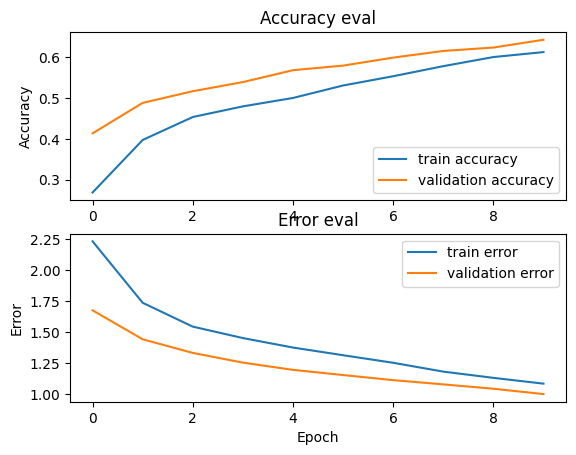

32/32 - 1s - loss: 0.9746 - accuracy: 0.6590

Test accuracy: 0.6589999794960022
MODEL SUCESSFULLY SAVED AT D:/Downloads/MGR Data/Data/GTZAN/Data/genres_original\Model.h5
Training Execution Time : 189.71810841560364 Seconds


In [38]:
training(path=DATASET_PATH,preprocess=True,remove=False)

#### path | filename | genre | name | array_index | test | error
- Here we will have row for each segment, where name will be os.path.splitext(filename)[0]_segment_augmentation
    - Example : How is life.mp3 -> How is life_3_2 means 3rd segment and 2nd augmentation as per our pipeline. 
- Test data will be selected first as per our previous logic and set aside so that segments of the test data doesn't get into training set. Augmentations will not be done as well on test data. 
- We will initially add segments of training onto dataframe then testing. Here testing array names for x.mp3 -> x_1_0 ....... x_n(segments)_0 since no augmentations done 
- Keeping track of array index will help us to continue adding data instead of creating memory maps each time there is change in dataset. This is assuming memory map is not hindered with and our dataset doesn't shrink in size i.e. we don't have to remove data from our dataframe. We can filter if that is the case provided the memory map exists since we keep track of array index.
- Error column will help us understand what all segments are problematic if error in segment. If x.mp3 file is unreadable then let array name be x and error is 'unreadable' while array index is empty.

